# 4. Evaluation Metrics for Classification

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('../data/lesson3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)


In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']


In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]


In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()


0.8034066713981547

## 4.2 Accuracy and dummy model
* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [10]:
len(y_val)

1409

In [11]:
(y_val == churn_decision).sum()

1132

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
thresholds = np.linspace(0,1,21)
scores = []
for t in thresholds:
    score = accuracy_score(y_val, (y_pred >= t))
    print('%.2f %.3f'%(t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


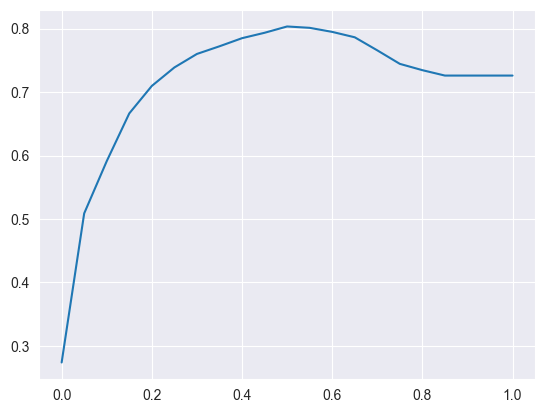

In [14]:
# 0.5 looks that the right threshold
plt.plot(thresholds, scores)

In [15]:
from collections import Counter
# with 1 as a threshold, it will only fail for the customers that churn, because the imbalance of values, 73% of the customers are not churning so it will be right 73% of the times.
Counter(y_val)

Counter({0: 1023, 1: 386})

## 4.3 Confusion table
* Different types of errors and correct decisions
* Arranging them in a table

In [16]:
t = 0.5
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
pred_positive = (y_pred >= t)
pred_negative = (y_pred < t)

In [17]:
tp = (pred_positive & actual_positive).sum()
tn = (pred_negative & actual_negative).sum()
tp, tn

(210, 922)

In [18]:
fp = (pred_positive & actual_negative).sum()
fn = (pred_negative & actual_positive).sum()
fp, fn

(101, 176)

In [19]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall
Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives.

In [21]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

Precision is the fraction of positive predictions that are correct

In [22]:
precision = tp / (tp + fp)
precision

0.6752411575562701

Recall is the fraction of correctly identified positive examples

In [23]:
recall = tp / (tp + fn)
recall

0.5440414507772021

Accuracy can be misleading, for this model recall and precision are not that good.

## 4.5 ROC Curves
### TPR and FRP
FPR (false positive ratio) is the fraction of false positives over all positives examples
TPR (true positive ratio) is the fraction of true positives over all positives examples


In [24]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tpr, fpr

(0.5440414507772021, 0.09872922776148582)

In [25]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        tp = (pred_positive & actual_positive).sum()
        tn = (pred_negative & actual_negative).sum()
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

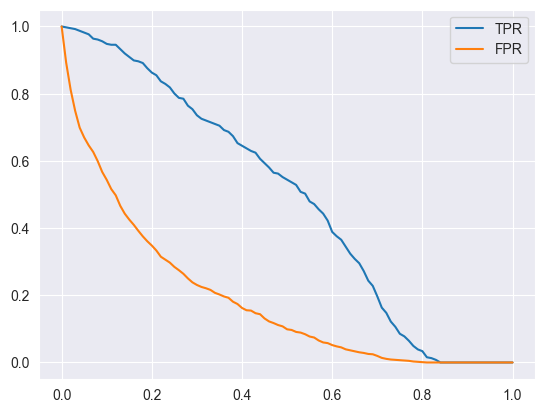

In [26]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [27]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [28]:
(y_rand >= 0.5).mean()

0.511000709723208

In [29]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

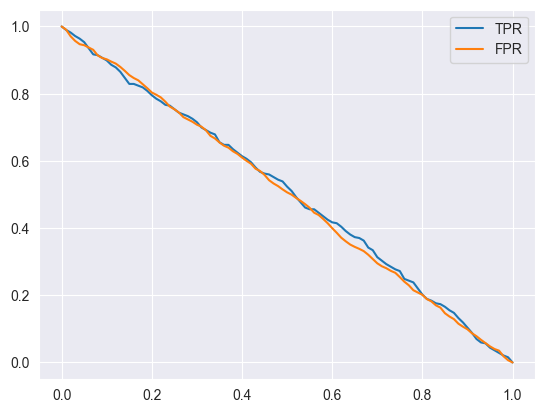

In [30]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [31]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_pos, num_neg

(386, 1023)

In [32]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
y_ideal_pred = np.linspace(0,1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [34]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [35]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

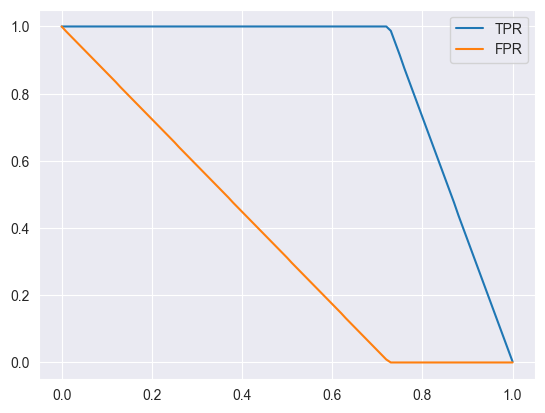

In [36]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

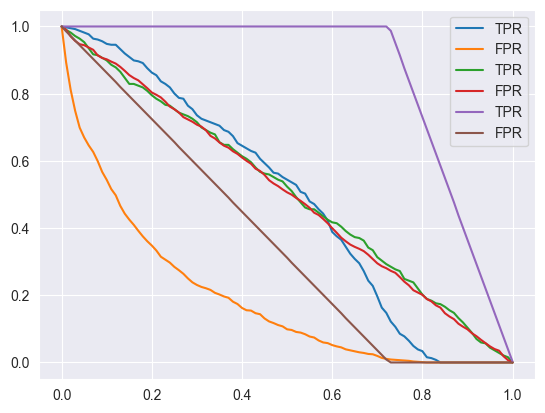

In [37]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

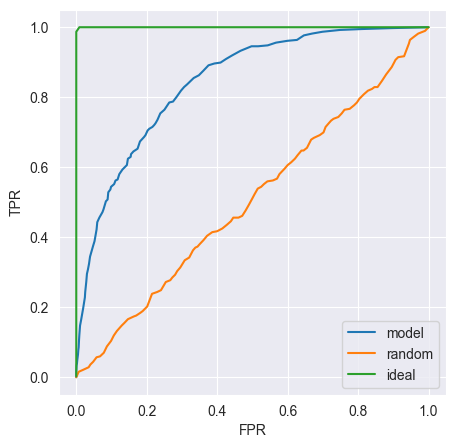

In [38]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

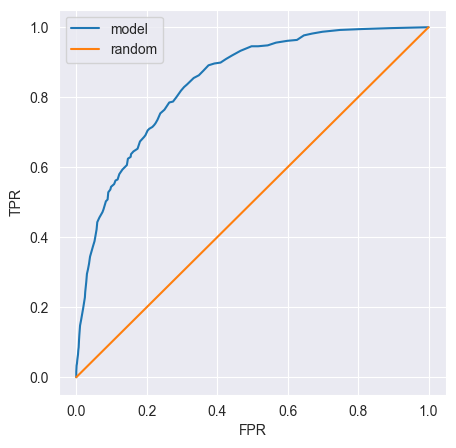

In [39]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### Using sklearn

In [40]:
from sklearn.metrics import roc_curve

In [41]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

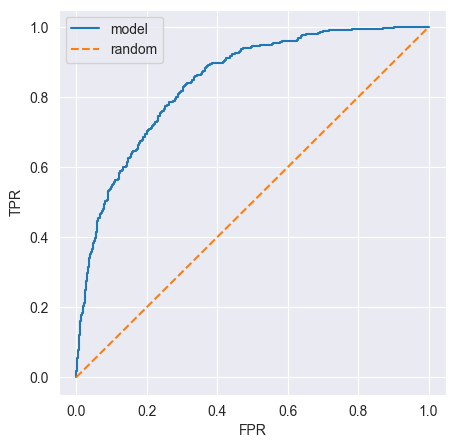

In [42]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## 4.6 ROC AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

In [43]:
from sklearn.metrics import auc

In [44]:
auc(fpr, tpr)

0.843850505725819

In [45]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

AUC: probability that a randomly selected positive example has higher score than a randomly selected negative example.

In [46]:
import random

In [47]:
neg_examples = y_pred[y_val == 0]
pos_examples = y_pred[y_val == 1]

# Comparing a lot of times the score of a random positive example with a negative example.
# The percentage of times that pos > neg is the auc.
results = []
n = 1000000
for i in range(n):
    pos_ind = random.randint(0, len(pos_examples) - 1)
    neg_ind = random.randint(0, len(neg_examples) - 1)

    results.append(pos_examples[pos_ind] > neg_examples[neg_ind])

sum(results) / n

0.843659

In [48]:
# Using numpy
pos_idxs = np.random.randint(0, len(pos_examples), size=100000)
neg_idxs = np.random.randint(0, len(neg_examples), size=100000)

(pos_examples[pos_idxs] > neg_examples[neg_idxs]).mean()

0.84297

## 4.7 Cross-Validation
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions


In [49]:
def train(df, y, c=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(max_iter=1000, C=c)
    model.fit(X_train, y)

    return dv, model

In [50]:
dv, model = train(df_train, y_train)


In [51]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred


In [52]:
y_pred = predict(df_val, dv, model)


In [53]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


In [54]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)


In [55]:
!pip install tqdm

In [56]:
from tqdm.auto import tqdm

In [57]:
scores = []
for train_idxs, val_idxs in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idxs]
    df_val = df_full_train.iloc[val_idxs]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    scores.append(roc_auc_score(y_val, y_pred))

print('%.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.840 +/- 0.012


In [58]:
n_split = 5
for c in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)
    for train_idxs, val_idxs in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idxs]
        df_val = df_full_train.iloc[val_idxs]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    print('%s -> %.3f +/- %.3f' % (c, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

0.001 -> 0.825 +/- 0.009
0.01 -> 0.840 +/- 0.009
0.1 -> 0.840 +/- 0.008
0.5 -> 0.841 +/- 0.006
1 -> 0.841 +/- 0.008
5 -> 0.841 +/- 0.007
10 -> 0.841 +/- 0.008


In [59]:
dv, model = train(df_full_train, df_full_train.churn.values, c=1)
y_pred = predict(df_test, dv, model)
score = roc_auc_score(y_test, y_pred)
score


0.8572386167896259

## 4.8 Summary
* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)


## 4.9 Explore more
1. Check the precision and recall of the dummy classifier that always predict "FALSE"
2. F1 score = 2 * P * R / (P + R)
3. Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
4. Area under the PR curve is also a useful metric

In [60]:
# 1
df = df_train.copy()
y_val = df.churn.values

y_pred = np.repeat(0, len(y_val))

t = 0.5
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
pred_positive = (y_pred >= t)
pred_negative = (y_pred < t)

tp = (pred_positive & actual_positive).sum()
tn = (pred_negative & actual_negative).sum()
fp = (pred_positive & actual_negative).sum()
fn = (pred_negative & actual_positive).sum()

tp, tn, fp, fn

(0, 3301, 0, 1207)

In [61]:
# For a model that predicts always 0, the precision will divide by 0 (true positives and false positives are 0)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
recall, precision

/var/folders/jr/yyrb479547l4qcrxdj0t48kc0000gn/T/ipykernel_64097/4070486982.py:2: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


(0.0, nan)

In [62]:
# 2
def recall_precision_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        tp = (pred_positive & actual_positive).sum()
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        scores.append((t, precision, recall))
    df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])
    df_scores['pr'] = df_scores.precision / df_scores.recall
    df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

    return df_scores

In [63]:
df = df_train.copy()
df_v = df_val.copy()

y_df = df.churn.values
y_v_df = df_v.churn.values

del df['churn']
del df_v['churn']

dv, model = train(df, y_df)
y_pred = predict(df_v, dv, model)

In [64]:
df_scores = recall_precision_dataframe(y_v_df, y_pred)
df_scores

/var/folders/jr/yyrb479547l4qcrxdj0t48kc0000gn/T/ipykernel_64097/87302960.py:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,threshold,precision,recall,pr,f1
0,0.00,0.278863,1.000000,0.278863,0.436111
1,0.01,0.305963,0.996815,0.306940,0.468212
2,0.02,0.321318,0.993631,0.323378,0.485603
3,0.03,0.341009,0.990446,0.344298,0.507341
4,0.04,0.358295,0.990446,0.361751,0.526227
...,...,...,...,...,...
96,0.96,NaN,0.000000,NaN,NaN
97,0.97,NaN,0.000000,NaN,NaN
98,0.98,NaN,0.000000,NaN,NaN
99,0.99,NaN,0.000000,NaN,NaN


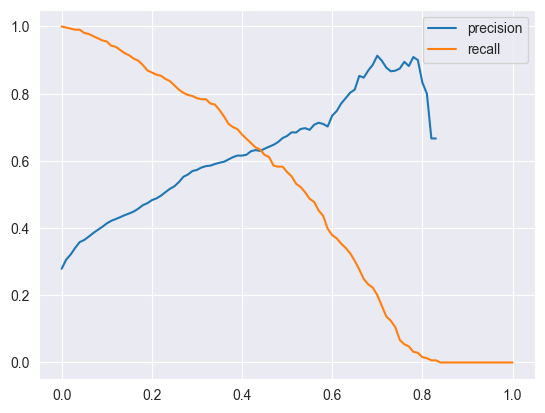

In [65]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

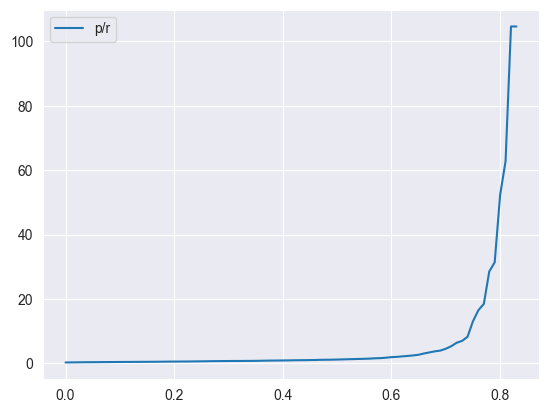

In [66]:
plt.plot(df_scores.threshold, df_scores['pr'], label='p/r')
plt.legend()

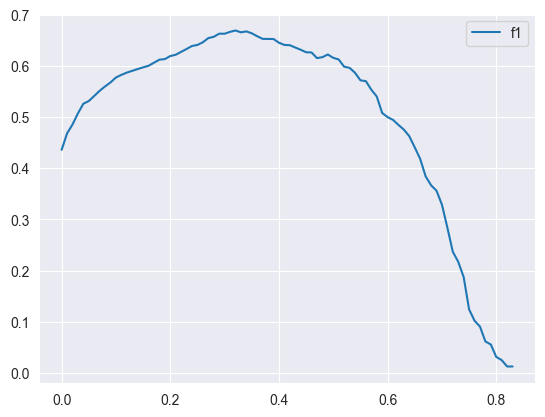

In [73]:
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()


### Precision-recall curve
A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve.
Generally, the use of ROC curves and precision-recall curves are as follows:
* ROC curves should be used when there are roughly equal numbers of observations for each class.
* Precision-Recall curves should be used when there is a moderate to large class imbalance.


In [74]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


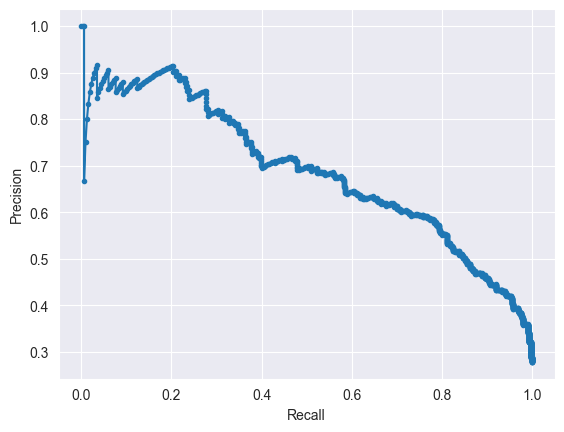

In [75]:
lr_precision, lr_recall, _ = precision_recall_curve(y_v_df, y_pred)
lr_auc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
